In [1]:
import pandas as pd 
import regex as re
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
%matplotlib inline

In [2]:
#Load the datasets:
items_order = pd.read_csv('olist_order_items_dataset.csv')
payments_order = pd.read_csv('olist_order_payments_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')

In [3]:
items_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [4]:
items_order.duplicated().sum()


0

In [5]:
#Convert order_item_id to string object
items_order["order_item_id"] = items_order['order_item_id'].astype('str')

#Convert shipping_limit_date to datetime
items_order["shipping_limit_date"] = pd.to_datetime(items_order["shipping_limit_date"])

In [6]:
#Confirm the datatype change
items_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   order_id             112650 non-null  object        
 1   order_item_id        112650 non-null  object        
 2   product_id           112650 non-null  object        
 3   seller_id            112650 non-null  object        
 4   shipping_limit_date  112650 non-null  datetime64[ns]
 5   price                112650 non-null  float64       
 6   freight_value        112650 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 6.0+ MB


In [7]:
payments_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [8]:
payments_order.duplicated().sum()

0

In [9]:
payments_order.isna().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [11]:
orders.duplicated().sum()


0

In [12]:
#Check orders df for null values()
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [13]:
#Update timestamp columns to the correct datatype
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

In [14]:
#Confirm the datatype change for timestamp coolumns
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [15]:
#Review rows with no approved dates
unapproved = orders[orders['order_approved_at'].isna()]
unapproved.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaT,NaT,NaT,2018-09-12
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaT,NaT,NaT,2018-10-17
1868,df8282afe61008dc26c6c31011474d02,aa797b187b5466bc6925aaaa4bb3bed1,canceled,2017-03-04 12:14:30,NaT,NaT,NaT,2017-04-10
2029,8d4c637f1accf7a88a4555f02741e606,b1dd715db389a2077f43174e7a675d07,canceled,2018-08-29 16:27:49,NaT,NaT,NaT,2018-09-13
2161,7a9d4c7f9b068337875b95465330f2fc,7f71ae48074c0cfec9195f88fcbfac55,canceled,2017-05-01 16:12:39,NaT,NaT,NaT,2017-05-30


In [16]:
#Confirming the order status of orders without approved dates
unapproved.order_status.value_counts().reset_index()

,index,order_status
0,canceled,141
1,delivered,14
2,created,5


In [17]:
#Extract unapproved but delivered orders
unapproved_delivered = ((orders['order_approved_at'].isna()) & (orders['order_status'] == 'delivered'))

#Update approval time for delivered orders to purchase time.
orders.loc[unapproved_delivered, "order_approved_at"]= orders.loc[unapproved_delivered, "order_purchase_timestamp"]
orders.loc[unapproved_delivered,:]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,2017-02-18 14:40:00,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,2017-02-18 12:45:31,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,2017-02-18 13:29:47,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,2017-02-18 16:48:35,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,2017-02-17 13:05:55,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20
26800,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,2017-01-19 12:48:08,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01
38290,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,2017-02-19 01:28:47,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27
39334,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,2017-02-18 11:04:19,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22
48401,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,2017-01-19 22:26:59,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16
61743,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,2017-02-17 17:21:55,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20


In [18]:
#Review rows with no carrier dates
non_carrier = orders[orders['order_delivered_carrier_date'].isna()]
non_carrier.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaT,NaT,2017-12-05
324,d3c8851a6651eeff2f73b0e011ac45d0,957f8e082185574de25992dc659ebbc0,processing,2016-10-05 22:44:13,2016-10-06 15:51:05,NaT,NaT,2016-12-09


In [19]:
#Confirming the order status of orders without carrier dates
non_carrier.order_status.value_counts()

unavailable    609
canceled       550
invoiced       314
processing     301
created          5
approved         2
delivered        2
Name: order_status, dtype: int64

In [20]:
#Confirm delivery status of rows withou carrier dates
non_carrier.query("order_status == 'delivered'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
73222,2aa91108853cecb43c84a5dc5b277475,afeb16c7f46396c0ed54acb45ccaaa40,delivered,2017-09-29 08:52:58,2017-09-29 09:07:16,NaT,2017-11-20 19:44:47,2017-11-14
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23


In [21]:
#Extract delivered orders without carrier dates
delivered_noncarrier = (orders['order_delivered_carrier_date'].isna()) & (orders['order_status'] == 'delivered')

#Update carrier time for delivered orders to purchase time
orders.loc[delivered_noncarrier, "order_delivered_carrier_date"] = orders.loc[delivered_noncarrier, "order_purchase_timestamp"]
orders.loc[delivered_noncarrier, :]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
73222,2aa91108853cecb43c84a5dc5b277475,afeb16c7f46396c0ed54acb45ccaaa40,delivered,2017-09-29 08:52:58,2017-09-29 09:07:16,2017-09-29 08:52:58,2017-11-20 19:44:47,2017-11-14
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,2017-05-25 23:22:43,NaT,2017-06-23


In [22]:
##Review rows with no delivery dates
undelivered = orders[orders['order_delivered_customer_date'].isna()]
undelivered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07


In [23]:
#Confirming the order status of orders without delivery dates
undelivered.order_status.value_counts()

shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: order_status, dtype: int64

In [24]:
undelivered.query("order_status == 'delivered'")


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,2017-05-25 23:22:43,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


In [25]:
#Compute delivery time
avg_delivery_time= (orders["order_delivered_customer_date"] - orders["order_delivered_carrier_date"]).mean()
avg_delivery_time

Timedelta('9 days 07:56:37.872558978')

In [26]:
#Extract delivered orders without delivery dates
delivered_nodelivery_date = (orders["order_delivered_customer_date"].isna() & (orders["order_status"] == 'delivered'))

In [27]:
#Replace non_delivery dates with a sum of the carrier date and the average delivery time
orders.loc[delivered_nodelivery_date,"order_delivered_customer_date"] = orders.loc[delivered_nodelivery_date,"order_delivered_carrier_date"] + avg_delivery_time
orders.loc[delivered_nodelivery_date,:]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,2017-12-10 02:09:00.872558978,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,2018-07-04 16:01:37.872558978,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,2018-07-12 21:53:37.872558978,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,2018-07-12 21:53:37.872558978,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,2018-07-12 17:24:37.872558978,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,2017-05-25 23:22:43,2017-06-04 07:19:20.872558978,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,2018-06-21 22:06:37.872558978,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,2018-07-13 03:22:37.872558978,2018-07-19


In [28]:
# Compute delivery duration in days and hours for all orders
orders["delivery_duration"] = (orders["order_delivered_customer_date"] - orders["order_delivered_carrier_date"])
orders["delivery_hours"] = orders["delivery_duration"]/ dt.timedelta(hours=1)
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_duration,delivery_hours
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,6 days 01:30:13,145.503611
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,12 days 00:56:45,288.945833
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9 days 04:16:29,220.274722
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,9 days 10:48:43,226.811944
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1 days 22:30:28,46.507778


In [29]:
orders.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   order_id                       99441 non-null  object         
 1   customer_id                    99441 non-null  object         
 2   order_status                   99441 non-null  object         
 3   order_purchase_timestamp       99441 non-null  datetime64[ns] 
 4   order_approved_at              99295 non-null  datetime64[ns] 
 5   order_delivered_carrier_date   97660 non-null  datetime64[ns] 
 6   order_delivered_customer_date  96484 non-null  datetime64[ns] 
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns] 
 8   delivery_duration              96484 non-null  timedelta64[ns]
 9   delivery_hours                 96484 non-null  float64        
dtypes: datetime64[ns](5), float64(1), object(3), timedelta64[ns](1)
memory

In [30]:
#Create Master df
Master_df = orders.merge(payments_order, on="order_id") \
.merge(items_order, on="order_id")
#Confirm shape and datatype of master df
Master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117601 entries, 0 to 117600
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype          
---  ------                         --------------   -----          
 0   order_id                       117601 non-null  object         
 1   customer_id                    117601 non-null  object         
 2   order_status                   117601 non-null  object         
 3   order_purchase_timestamp       117601 non-null  datetime64[ns] 
 4   order_approved_at              117601 non-null  datetime64[ns] 
 5   order_delivered_carrier_date   116358 non-null  datetime64[ns] 
 6   order_delivered_customer_date  115042 non-null  datetime64[ns] 
 7   order_estimated_delivery_date  117601 non-null  datetime64[ns] 
 8   delivery_duration              115042 non-null  timedelta64[ns]
 9   delivery_hours                 115042 non-null  float64        
 10  payment_sequential             117601 non-null  int64   

In [31]:
#Checking null values
Master_df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date     1243
order_delivered_customer_date    2559
order_estimated_delivery_date       0
delivery_duration                2559
delivery_hours                   2559
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
dtype: int64

In [32]:
#Check for duplicate rows
Master_df.duplicated().sum()

0

In [33]:
#Drop duplicate rows if any
Master_df.drop_duplicates(inplace=True)

#Confirm there are no duplicate rows
Master_df.duplicated().sum()

0

In [34]:
#Confirmimg rows without carrier (pick-up) and delivery date
ad = Master_df[(Master_df['order_delivered_carrier_date'].isna()) | (Master_df['order_delivered_customer_date'].isna())]
ad['order_status'].value_counts()

shipped        1244
canceled        559
processing      375
invoiced        371
unavailable       7
approved          3
Name: order_status, dtype: int64

In [35]:
#Remove columns of object data types
Model_df = Master_df.select_dtypes(exclude= object)
Model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117601 entries, 0 to 117600
Data columns (total 13 columns):
 #   Column                         Non-Null Count   Dtype          
---  ------                         --------------   -----          
 0   order_purchase_timestamp       117601 non-null  datetime64[ns] 
 1   order_approved_at              117601 non-null  datetime64[ns] 
 2   order_delivered_carrier_date   116358 non-null  datetime64[ns] 
 3   order_delivered_customer_date  115042 non-null  datetime64[ns] 
 4   order_estimated_delivery_date  117601 non-null  datetime64[ns] 
 5   delivery_duration              115042 non-null  timedelta64[ns]
 6   delivery_hours                 115042 non-null  float64        
 7   payment_sequential             117601 non-null  int64          
 8   payment_installments           117601 non-null  int64          
 9   payment_value                  117601 non-null  float64        
 10  shipping_limit_date            117601 non-null  datetime

In [36]:
#Dropping other irrelevant date columns except the purchase date
Model_df.drop(columns=["order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date", "delivery_duration", "shipping_limit_date", "order_approved_at"], axis=1, inplace=True)

In [37]:
#Group the model dataset by the purchase date
Model_df = Model_df.groupby("order_purchase_timestamp").mean()

In [38]:
#Confirm the presence of null values
Model_df.isna().sum()

#Drop null rows if present
Model_df.dropna(inplace=True)

In [39]:
Model_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95961 entries, 2016-10-03 09:44:50 to 2018-08-29 15:00:37
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   delivery_hours        95961 non-null  float64
 1   payment_sequential    95961 non-null  float64
 2   payment_installments  95961 non-null  float64
 3   payment_value         95961 non-null  float64
 4   price                 95961 non-null  float64
 5   freight_value         95961 non-null  float64
dtypes: float64(6)
memory usage: 5.1 MB


In [40]:
# Extract predictor and target variables
y = Model_df["payment_value"]
X = Model_df.drop("payment_value", axis=1)


In [41]:
#Seperate train and test values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [42]:
#Build Random Forest Model
forest_model = RandomForestRegressor(random_state=1)

#Fit Model to train dataset
forest_model.fit(X_train, y_train)

#Use fitted model to predict sales
sales_preds = forest_model.predict(X_valid)
print(mean_absolute_error(y_valid, sales_preds))
print(r2_score(y_valid, sales_preds))
print(mean_squared_error(y_valid, sales_preds))

24.659924407704413
0.8609668083812517
5963.193055881664


In [43]:
#Build Decision Tree Model
decision_model = DecisionTreeRegressor(random_state=1, max_leaf_nodes=500)

#Fit Model to train dataset
decision_model.fit(X_train, y_train)

#Use fitted model to predict sales
sales_preds2 = decision_model.predict(X_valid)
print(mean_absolute_error(y_valid, sales_preds2))
print(r2_score(y_valid, sales_preds2))
print(mean_squared_error(y_valid, sales_preds2))

25.813514013962788
0.813885989609082
7982.5095104538495


In [44]:
#Comparing the sales prediction from the different models to the train dataset
compared_df = y_valid.reset_index()
compared_df["Rf"] = sales_preds
compared_df["DT"] = sales_preds2
compared_df.head(7)

,order_purchase_timestamp,payment_value,Rf,DT
0,2018-01-02 16:17:43,28.70,29.3809,27.716076
1,2018-08-06 09:14:00,64.66,41.7107,36.297827
2,2018-07-13 09:52:00,61.30,78.1226,75.100460
3,2018-05-20 17:21:49,35.71,35.8462,42.618790
4,2018-02-04 11:25:15,210.11,222.7414,239.287597
5,2017-03-19 17:06:25,204.52,208.4066,217.328356
6,2018-02-13 23:35:35,32.77,33.4052,36.297827


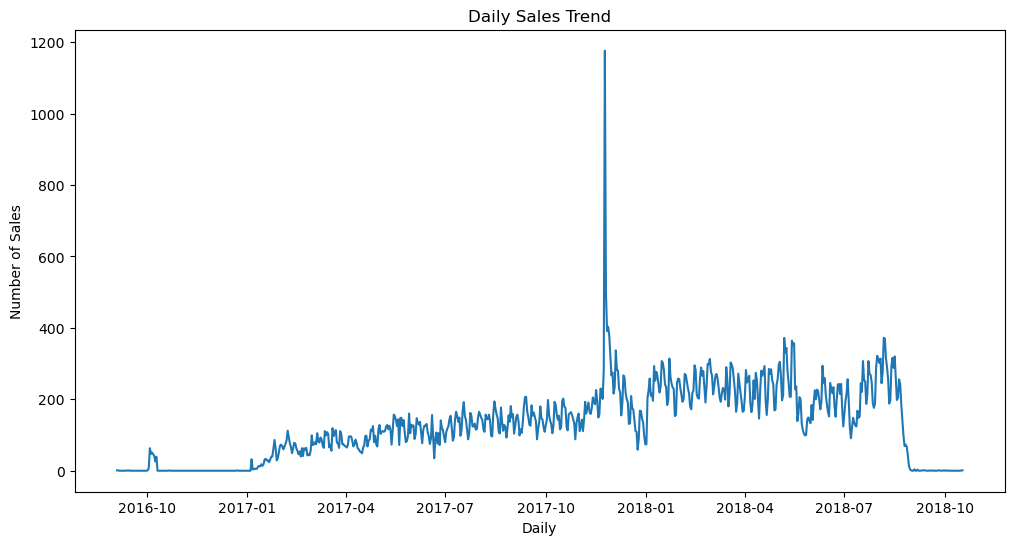

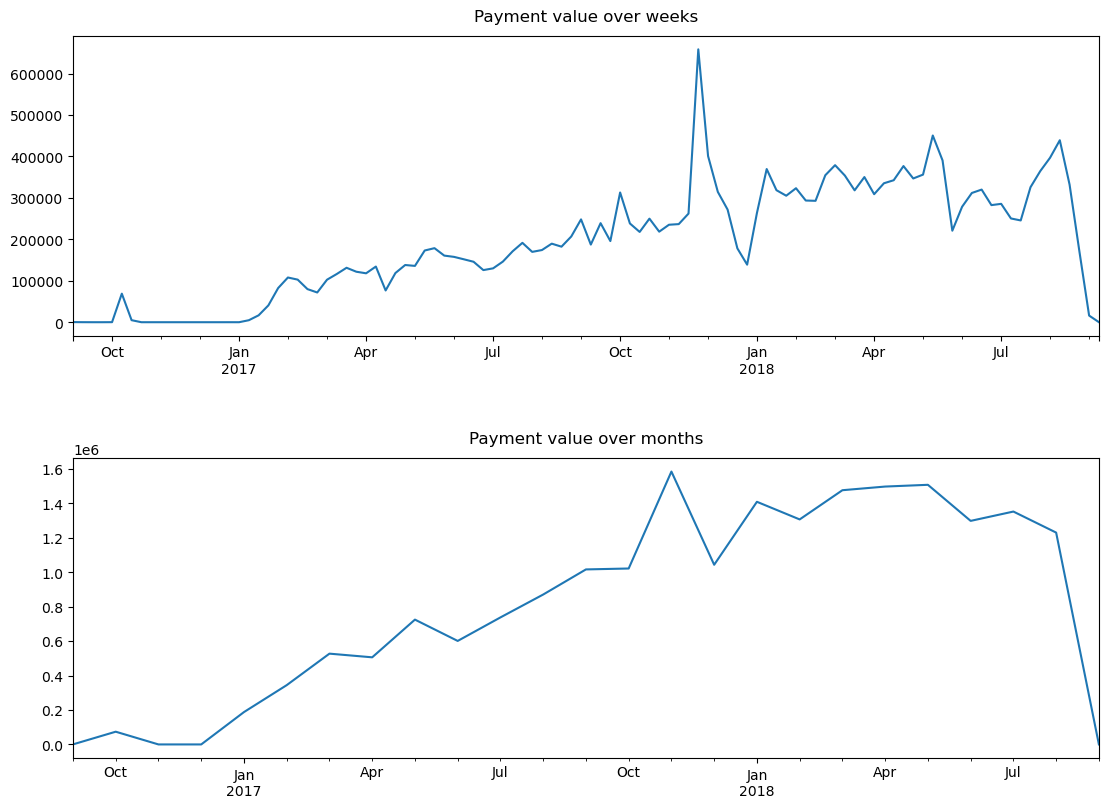

In [45]:
#Creating a plot to show payment value over time
#plt.figure(figsize = (10, 5))
#sns.lineplot(x = Master_df['order_purchase_timestamp'], y = Master_df['payment_value'], palette = 'viridis')
#plt.title('Payment value over time', fontdict = {'fontsize': 16}, pad = 10.5)

#plt.tight_layout()
#Show the graph for the payment
#import matplotlib.pyplot as plt
#Aggregate sales on a daily basis
daily_sales = orders.groupby(pd.Grouper(key='order_purchase_timestamp',freq='D'))['order_id'].count()
plt.figure(figsize=(12, 6))
plt.plot(daily_sales.index, daily_sales.values)
plt.title('Daily Sales Trend')
plt.xlabel('Daily')
plt.ylabel('Number of Sales')
plt.show()


#Creating other copy of merged_df 
data_2 = Master_df.copy(deep = True)
#Setting a index before resample the dataframe to month and week level
data_2 = data_2.set_index('order_purchase_timestamp')


#Plot resampled dataframe
plt.figure(figsize = (12, 9))

#First plot
plt.subplot(2,1,1)
data_2['payment_value'].resample('W').sum().plot()
plt.title('Payment value over weeks', fontdict = {'fontsize': 12}, pad = 10.5)
plt.xlabel(None)


#Second plot
plt.subplot(2,1,2)
data_2['payment_value'].resample('M').sum().plot()
plt.title('Payment value over months', fontdict = {'fontsize': 12}, pad = 10.5)
plt.xlabel(None)



plt.tight_layout(pad = 4)